# ОИАД. Лабораторная работа №3

Подготовка данных, построение многомерной линейной регрессии (аналитически и численно) и сравнение моделей на данных страховых выплат.


In [5]:
import ydata_profiling as ydp
import pandas as pd

df = pd.read_csv("../../datasets/insurance_train.csv")

profile = ydp.ProfileReport(df)
profile.to_file("insurance_train_report.html")


ModuleNotFoundError: No module named 'ydata_profiling'

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")


In [3]:
DATA_DIR = Path("../../datasets")
TRAIN_PATH = DATA_DIR / "insurance_train.csv"
TEST_PATH = DATA_DIR / "insurance_test.csv"

train_raw = pd.read_csv(TRAIN_PATH)
test_raw = pd.read_csv(TEST_PATH)

train_raw.head()


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


In [4]:
train_raw.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,338.0,NaN,NaN,NaN,38.810651,13.637734,18.0,27.0,38.0,50.0,64.0
sex,338,2,male,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,338.0,NaN,NaN,NaN,30.672751,6.309709,17.29,26.05375,30.065,34.595,53.13
children,338.0,NaN,NaN,NaN,1.153846,1.205822,0.0,0.0,1.0,2.0,5.0
smoker,338,2,no,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,338,4,southeast,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,338.0,NaN,NaN,NaN,14092.861924,12792.472722,1121.8739,4811.304137,9891.530425,19423.69905,63770.42801


In [5]:
train_raw.isna().mean()


age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [6]:
TARGET_COLUMN = "charges"


def encode_features(train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    X_train = train_df.drop(columns=[TARGET_COLUMN])
    X_test = test_df.drop(columns=[TARGET_COLUMN])

    categorical_cols = X_train.select_dtypes(include="object").columns.tolist()

    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    return X_train_enc, X_test_enc


def standardize_train_test(
    X_train: pd.DataFrame, X_test: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    mean = X_train.mean()
    std = X_train.std(ddof=0)
    std_replaced = std.replace(0, 1)

    X_train_scaled = (X_train - mean) / std_replaced
    X_test_scaled = (X_test - mean) / std_replaced

    return X_train_scaled, X_test_scaled, mean, std_replaced


def preprocess(train_df: pd.DataFrame, test_df: pd.DataFrame):
    X_train_enc, X_test_enc = encode_features(train_df, test_df)
    X_train_scaled, X_test_scaled, mean, std = standardize_train_test(X_train_enc, X_test_enc)

    y_train = train_df[TARGET_COLUMN].astype(float)
    y_test = test_df[TARGET_COLUMN].astype(float)

    return {
        "X_train_raw": X_train_enc,
        "X_test_raw": X_test_enc,
        "X_train": X_train_scaled,
        "X_test": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "feature_mean": mean,
        "feature_std": std,
    }


data = preprocess(train_raw, test_raw)
list(data.keys())


['X_train_raw',
 'X_test_raw',
 'X_train',
 'X_test',
 'y_train',
 'y_test',
 'feature_mean',
 'feature_std']

In [7]:
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

X_train.head()


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-0.940746,-0.573419,-0.958315,0.959403,1.825742,-0.556846,1.521094,-0.538587
1,1.409164,0.997124,0.702764,0.959403,1.825742,1.795828,-0.657422,-0.538587
2,-1.381354,-0.992442,-0.958315,-1.042315,1.825742,-0.556846,1.521094,-0.538587
3,0.895121,1.172511,-0.958315,-1.042315,1.825742,-0.556846,1.521094,-0.538587
4,1.702902,-0.900384,-0.958315,-1.042315,-0.547723,-0.556846,-0.657422,1.856709


In [8]:
train_for_corr = pd.concat([data["X_train_raw"], y_train], axis=1)
corr_matrix = train_for_corr.corr()

corr_matrix[TARGET_COLUMN].sort_values(ascending=False)


charges             1.000000
smoker_yes          0.783519
age                 0.298395
bmi                 0.219566
children            0.069444
sex_male            0.060221
region_southeast    0.009792
region_northwest   -0.032287
region_southwest   -0.053905
Name: charges, dtype: float64

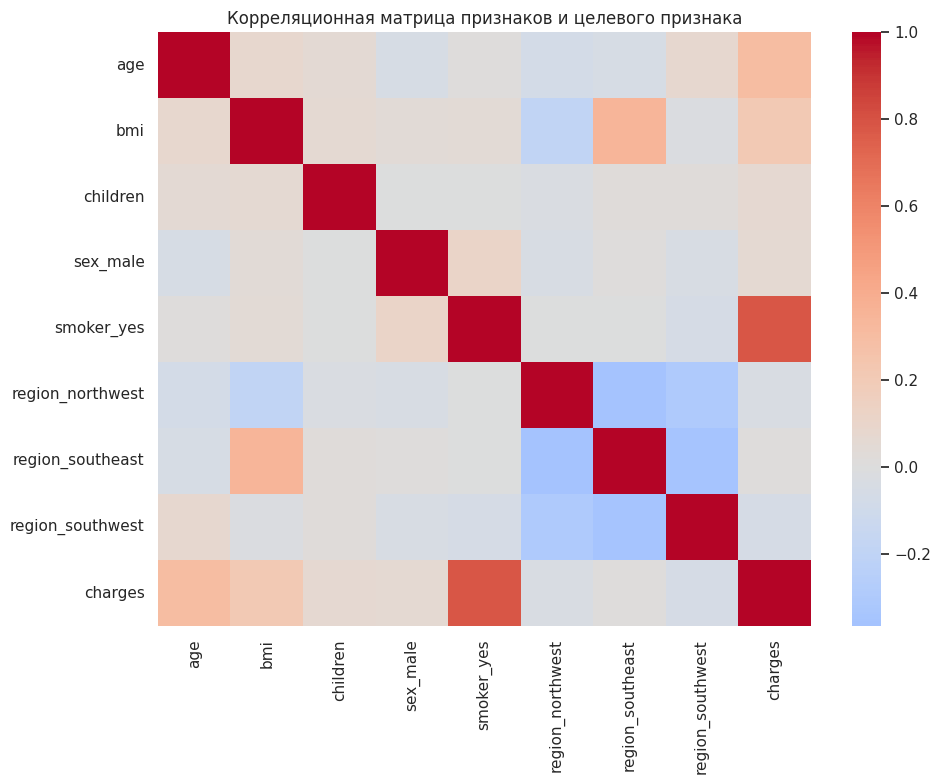

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Корреляционная матрица признаков и целевого признака")
plt.tight_layout()
plt.show()


In [10]:
def add_bias(X: np.ndarray) -> np.ndarray:
    return np.c_[np.ones((X.shape[0], 1)), X]


def normal_equation_solution(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    X_b = add_bias(X)
    theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
    return theta


def predict(theta: np.ndarray, X: np.ndarray) -> np.ndarray:
    X_b = add_bias(X)
    return X_b @ theta


def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)


X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values


In [11]:
theta_analytic = normal_equation_solution(X_train_np, y_train_np)

train_pred_analytic = predict(theta_analytic, X_train_np)
test_pred_analytic = predict(theta_analytic, X_test_np)

analytic_mse_train = mean_squared_error(y_train_np, train_pred_analytic)
analytic_mse_test = mean_squared_error(y_test_np, test_pred_analytic)

pd.Series(theta_analytic, index=["bias", *X_train.columns])


bias                14092.861924
age                  3495.769492
bmi                  2210.571768
children              581.675135
sex_male             -327.421295
smoker_yes           9859.845555
region_northwest      -85.259131
region_southeast     -638.001366
region_southwest     -601.390128
dtype: float64

In [12]:
def gradient_descent(
    X: np.ndarray,
    y: np.ndarray,
    learning_rate: float = 0.05,
    n_iters: int = 10_000,
    tol: float = 1e-8,
) -> tuple[np.ndarray, list[float]]:
    m, n = X.shape
    theta = np.zeros(n + 1)
    cost_history: list[float] = []

    for iteration in range(n_iters):
        predictions = predict(theta, X)
        errors = predictions - y
        gradients = (2 / m) * add_bias(X).T @ errors
        theta -= learning_rate * gradients

        cost = mean_squared_error(y, predictions)
        cost_history.append(cost)

        if iteration > 0 and abs(cost_history[-2] - cost_history[-1]) < tol:
            break

    return theta, cost_history


theta_gd, gd_history = gradient_descent(X_train_np, y_train_np)
len(gd_history), gd_history[-1]


(420, np.float64(44325092.02597622))

In [13]:
train_pred_gd = predict(theta_gd, X_train_np)
test_pred_gd = predict(theta_gd, X_test_np)

gd_mse_train = mean_squared_error(y_train_np, train_pred_gd)
gd_mse_test = mean_squared_error(y_test_np, test_pred_gd)

{
    "iters": len(gd_history),
    "train_mse": gd_mse_train,
    "test_mse": gd_mse_test,
    "final_cost": gd_history[-1],
}


{'iters': 420,
 'train_mse': np.float64(44325092.02597619),
 'test_mse': np.float64(34216008.49794279),
 'final_cost': np.float64(44325092.02597622)}

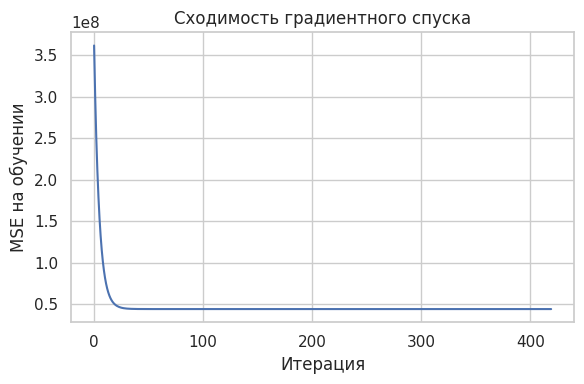

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(gd_history)
plt.xlabel("Итерация")
plt.ylabel("MSE на обучении")
plt.title("Сходимость градиентного спуска")
plt.tight_layout()
plt.show()


In [15]:
baseline_prediction = np.full_like(y_test_np, y_train_np.mean())
baseline_mse_test = mean_squared_error(y_test_np, baseline_prediction)

comparison = pd.DataFrame(
    {
        "Модель": [
            "Константная (среднее)",
            "Линейная регрессия (аналитически)",
            "Линейная регрессия (градиентный спуск)",
        ],
        "MSE train": [
            mean_squared_error(y_train_np, np.full_like(y_train_np, y_train_np.mean())),
            analytic_mse_train,
            gd_mse_train,
        ],
        "MSE test": [
            baseline_mse_test,
            analytic_mse_test,
            gd_mse_test,
        ],
    }
)
comparison


,Модель,MSE train,MSE test
0,Константная (среднее),1.631632e+08,1.418301e+08
1,Линейная регрессия (аналитически),4.432509e+07,3.421601e+07
2,Линейная регрессия (градиентный спуск),4.432509e+07,3.421601e+07


## Выводы

- Категориальные признаки закодированы методом one-hot, признаки стандартизированы по обучающей выборке.
- Наиболее сильно с целевой переменной коррелируют `smoker_yes`, `bmi` и `age`.
- Аналитическое решение и градиентный спуск сходятся к близким параметрам и заметно превосходят константную модель по MSE на тесте.
- Градиентный спуск достигает решения за ограниченное число итераций, что подтверждается убыванием ошибки на обучении.


### Что сделано

1. Проведена предобработка данных: категориальные переменные закодированы методом one-hot, числовые признаки стандартизированы по статистикам обучающей выборки.
2. Посчитаны попарные корреляции всех признаков с целевой переменной `charges`, построена тепловая карта для визуального анализа зависимостей.
3. Реализованы две версии линейной регрессии: аналитическое решение через нормальное уравнение и численное решение с помощью градиентного спуска с контролем сходимости.
4. Получены прогнозы на тренировочном и тестовом наборах, вычислены MSE, построена кривая обучения для градиентного спуска, сформирована таблица сравнения с константной моделью.

### Как интерпретировать результаты

1. Корреляционный анализ показывает, какие признаки сильнее всего связаны с расходами на страховку; например, положительная корреляция `smoker_yes` указывает на высокие дополнительные затраты для курильщиков.
2. Близкие значения MSE у аналитического решения и градиентного спуска подтверждают корректность реализации обоих методов и достаточную сходимость численного алгоритма.
3. Оба варианта линейной регрессии заметно превосходят константную модель по MSE на тесте, значит признаки действительно несут полезную информацию для прогноза.
4. График сходимости демонстрирует, что выбранные шаг обучения и критерий останова позволяют стабильно уменьшать ошибку; при необходимости можно изменить скорость обучения или число итераций для получения другого баланса между скоростью и точностью.
